In [1]:
import yfinance as yf
import numpy as np 
import pandas as pd
import requests
import json
import copy
from groq import Groq

In [2]:
indexId = {
    'tor-107': '1', 
    'tor-104': '2', 
    'chi-001': '3', 
    'dal-001': '4', 
    'lon-001': '5', 
    'sea-001': '6',
    'hkg-201': '7', 
    'tor-001': '8', 
    'mtr-004': '9', 
    'bkk-002': '10', 
    'sro-002': '11',
    'nyc-301': '12', 
    'nyc-302': "13", 
    'nyc-303': '14', 
    'nyc-401': '15', 
    'nyc-402': '16', 
    'nyc-403': '17',
}

In [3]:
keys = {
    'tor-107': 'JPZS9NJ731FFU6XD', 
    'tor-104': 'GS4M3AZ67F11P1H6', 
    'chi-001': 'DXCT5GK8UFM8ZU02', 
    'dal-001': 'OTDYJFDQMVUT09AD', 
    'lon-001': '6U29R2IASU2ZDQ9N', 
    'sea-001': '9O5Y94NK5A05ML70',
    'hkg-201': 'B4FG1SX0A9DO3BHE', 
    'tor-001': 'P5O52XFHHMN951JD', 
    'mtr-004' : '3EFJOOTTAELCYY2S', 
    'bkk-002': 'Q2YT6F4TZV0ZYMLA', 
    'sro-002': 'KDTHAW0LWKGDAM3P',
    'nyc-301':'UURKCYGN6GJ5M1U7', 
    'nyc-302': "DYMR6CLGGG8DY757", 
    'nyc-303': '4MHQKYN6HGMA4BV3', 
    'nyc-401': '9DR1N10MELFXQS5W', 
    'nyc-402': '0D1JR0X3U38LNAYO', 
    'nyc-403': 'AAUJB67LMZ7EO4DX',
}

In [7]:
keyCalls = 0
currentKey =1

In [8]:
url = "https://api.usfundamentals.com/v1/companies/xbrl"

In [9]:
contracts = pd.read_csv("data/contracts_data.csv")
contracts_test = contracts[contracts["Start Date"].str.match(r"^\d{4}-\d{2}-\d{2}$", na=False)]
contracts_test["Start Date"] = pd.to_datetime(contracts_test["Start Date"])
contracts_test = contracts_test.sort_values(by="Start Date")

/tmp/ipykernel_6458/70418442.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contracts_test["Start Date"] = pd.to_datetime(contracts_test["Start Date"])


In [10]:
client = Groq(api_key="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")

In [11]:
def getTicker(company): 
    completion = client.chat.completions.create(
        model="gemma2-9b-it",
        messages=[
            {
                "role": "system",
                "content": "Identify publicly traded companies that have a positive correlation with a given company. consider other companies that would benefit from this company thriving, while excluding direct competitors who might not experience the same positive effect. Also, provide any parent or subsidiary companies that are publicly traded, including the company itself if applicable. \n\n# Required Information:\n- Given company name.\n\n# Details to Include:\n- List companies that have a positive correlation with the given company if it receives a large (>100M USD) government contract.\n- Include companies positively influenced by this event or that have a linked dependency, excluding direct competitors as they might not benefit under the same conditions.\n- Include parent or subsidiary companies of the given company, if they are publicly traded.\n- Include the given company itself if it is publicly traded.\n\n# Output Format:\n\nProvide a list ordered by correlation to the given company separated by a comma of their TICKERS ONLY. do not include further information or notes. Return N/A if the company is not publicly traded.\n\n[TICKER]\n\n"
            }, 
            {
                "role": "user",
                "content": f"is {company}"
            },
        ],
        temperature=1.12,
        max_tokens=1024,
        top_p=1,
        stream=True,
        stop=None,
    )

    full_response = ""
    for chunk in completion:
        if chunk.choices[0].delta and chunk.choices[0].delta.content:
            full_response+=(chunk.choices[0].delta.content)
    return full_response

In [12]:
filtered_df = contracts_test[
    (contracts_test["Start Date"] >= pd.Timestamp("2016-01-01")) & 
    (contracts_test["Start Date"] <= pd.Timestamp("2023-12-31"))
]
filtered_df[:100]

,internal_id,Award ID,Recipient Name,Award Amount,Total Outlays,Description,Contract Award Type,def_codes,COVID-19 Obligations,COVID-19 Outlays,...,Infrastructure Outlays,Awarding Agency,Awarding Sub Agency,Start Date,End Date,recipient_id,prime_award_recipient_id,awarding_agency_id,agency_slug,generated_internal_id
7772,1429690,0025,"LEIDOS, INC.",105433903.26,NaN,IGF::CL::IGF VENDOR MAINTENANCE AGREEMENTS (VMAS),DELIVERY ORDER,NaN,NaN,NaN,...,NaN,Department of Defense,Defense Information Systems Agency,2016-01-01,2016-12-31,32109085-1976-8da6-d5cd-7c8077389b75-C,NaN,1173,department-of-defense,CONT_AWD_0025_9700_HC102812D0021_9700
2233,37476110,W58RGZ16C0008,LOCKHEED MARTIN CORP,356682343.49,43225448.86,"IGF::CL,CT::IGF CONTRACT W58RGZ-16-C-0008 IS H...",DEFINITIVE CONTRACT,['Q'],NaN,NaN,...,NaN,Department of Defense,Department of the Army,2016-01-01,2021-06-30,695d5739-ecc3-8484-ba2b-f9c8b4652a4a-C,NaN,1173,department-of-defense,CONT_AWD_W58RGZ16C0008_9700_-NONE-_-NONE-
15471,775359,0008,NORTHROP GRUMMAN SYSTEMS CORPORATION,54292651.96,NaN,IGF::OT::IGF CONTRACTOR LOGISTICS SUPPORT FOR ...,DELIVERY ORDER,NaN,NaN,NaN,...,NaN,Department of Defense,Department of the Air Force,2016-01-01,2016-12-31,75dec7b1-56eb-4770-da4b-ac736121ab61-C,NaN,1173,department-of-defense,CONT_AWD_0008_9700_FA852313D0002_9700
7205,37394610,W31P4Q16C0028,RAYTHEON COMPANY,114181051.0,NaN,UCA FOR PBL,DEFINITIVE CONTRACT,NaN,NaN,NaN,...,NaN,Department of Defense,Department of the Army,2016-01-01,2019-12-31,cce9df51-3950-87f4-0b34-4353d5a08f32-C,NaN,1173,department-of-defense,CONT_AWD_W31P4Q16C0028_9700_-NONE-_-NONE-
10261,32046094,TIRNO11D000240009,"LEIDOS MANAGEMENT SYSTEMS DESIGNERS, INC.",80382264.57,34146605.46,IGF::CT::IGF FOR CRITICAL FUNCTIONS - PAPER AN...,DELIVERY ORDER,"['O', 'Q']",1238280.93,1238280.93,...,NaN,Department of the Treasury,Internal Revenue Service,2016-01-01,2021-06-30,620902f5-ab14-cea5-c2c6-adbe6f4c83f8-C,NaN,456,department-of-the-treasury,CONT_AWD_TIRNO11D000240009_2050_TIRNO11D00024_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16580,14284205,EPG16H01256,"GENERAL DYNAMICS INFORMATION TECHNOLOGY, INC.",50783155.36,18081454.46,IGF::OT::IGF: OFFICE OF RESEARCH AND DEVELOP...,DELIVERY ORDER,['Q'],NaN,NaN,...,NaN,Environmental Protection Agency,Environmental Protection Agency,2016-02-01,2024-07-30,455555be-773d-eab1-1e6b-7b94400b757e-C,NaN,700,environmental-protection-agency,CONT_AWD_EPG16H01256_6800_HHSN316201200013W_7529
33781,21857376,GSQ0116BK0054,SCIENCE APPLICATIONS INTERNATIONAL CORPORATION,26273941.24,NaN,IGF::OT::IGF QUICK REACTION CAPABILITY BATTLE ...,DELIVERY ORDER,NaN,NaN,NaN,...,NaN,General Services Administration,Federal Acquisition Service,2016-02-01,2018-02-01,20af0683-f17d-1f8f-38ee-2f11bd124559-C,NaN,614,general-services-administration,CONT_AWD_GSQ0116BK0054_4732_GS00F002CA_4732
3654,1485808,0027,THE BOEING COMPANY,222247208.51,NaN,IGF::OT::IGF FY16 SUSTAINMENT MATERIAL IN SUPP...,DELIVERY ORDER,NaN,NaN,NaN,...,NaN,Department of Defense,Defense Contract Management Agency,2016-02-01,2016-09-30,2bf5d203-604f-4c6c-7c7b-4ad81a350613-C,NaN,1173,department-of-defense,CONT_AWD_0027_9700_FA852612D0001_9700
2024,28112079,SECHQ116C0032,"GENERAL DYNAMICS INFORMATION TECHNOLOGY, INC.",386853268.2,238838491.93,INFRASTRUCTURE SUPPORT SERVICES (ISS) IGF::OT:...,DEFINITIVE CONTRACT,['Q'],NaN,NaN,...,NaN,Securities and Exchange Commission,Securities and Exchange Commission,2016-02-01,2024-12-31,455555be-773d-eab1-1e6b-7b94400b757e-C,NaN,680,securities-and-exchange-commission,CONT_AWD_SECHQ116C0032_5000_-NONE-_-NONE-


In [16]:

indexKey = {
    '0': 'V9OIJQ16HHDKVYOJ', 
    '1': 'A75JKLMQIWJKIY96', 
    '2': 'DXCT5GK8UFM8ZU02', 
    '3': 'OTDYJFDQMVUT09AD', 
    '4': '6U29R2IASU2ZDQ9N', 
    '5': '9O5Y94NK5A05ML70',
    '6': 'B4FG1SX0A9DO3BHE', 
    '7': 'P5O52XFHHMN951JD', 
    '8' : '3EFJOOTTAELCYY2S', 
    '9': 'Q2YT6F4TZV0ZYMLA', 
    '10': 'KDTHAW0LWKGDAM3P',
    '11':'UURKCYGN6GJ5M1U7', 
    '12': "DYMR6CLGGG8DY757", 
    '13': '4MHQKYN6HGMA4BV3', 
    '14': '9DR1N10MELFXQS5W', 
    '15': '0D1JR0X3U38LNAYO', 
    '16': 'AAUJB67LMZ7EO4DX',
}


In [36]:
def setParams(ticker, itv, date):
    key = f'{currentKey}'
    params = {
        "function": "TIME_SERIES_INTRADAY", 
        "symbol" : ticker, 
        "interval" : itv, 
        "adjusted" : "false", 
        "month" : date, 
        "outputsize":"full", 
        "datatype" : "json", 
        "apikey": indexKey[key]
    }
    return params 

In [18]:
alphV = "https://www.alphavantage.co/query"
historic = requests.get(url=alphV, params= setParams("AAPL", "15min", "2009-01"))
print(historic.json().keys())

dict_keys(['Meta Data', 'Time Series (15min)'])


In [19]:
historic.json()['Meta Data']

{'1. Information': 'Intraday (15min) open, high, low, close prices and volume',
 '2. Symbol': 'AAPL',
 '3. Last Refreshed': '2009-01-30 19:45:00',
 '4. Interval': '15min',
 '5. Output Size': 'Full size',
 '6. Time Zone': 'US/Eastern'}

In [20]:
historic.json()['Time Series (15min)'].keys()

dict_keys(['2009-01-30 19:45:00', '2009-01-30 19:30:00', '2009-01-30 19:15:00', '2009-01-30 19:00:00', '2009-01-30 18:45:00', '2009-01-30 18:30:00', '2009-01-30 18:15:00', '2009-01-30 18:00:00', '2009-01-30 17:45:00', '2009-01-30 17:30:00', '2009-01-30 17:15:00', '2009-01-30 17:00:00', '2009-01-30 16:45:00', '2009-01-30 16:30:00', '2009-01-30 16:15:00', '2009-01-30 16:00:00', '2009-01-30 15:45:00', '2009-01-30 15:30:00', '2009-01-30 15:15:00', '2009-01-30 15:00:00', '2009-01-30 14:45:00', '2009-01-30 14:30:00', '2009-01-30 14:15:00', '2009-01-30 14:00:00', '2009-01-30 13:45:00', '2009-01-30 13:30:00', '2009-01-30 13:15:00', '2009-01-30 13:00:00', '2009-01-30 12:45:00', '2009-01-30 12:30:00', '2009-01-30 12:15:00', '2009-01-30 12:00:00', '2009-01-30 11:45:00', '2009-01-30 11:30:00', '2009-01-30 11:15:00', '2009-01-30 11:00:00', '2009-01-30 10:45:00', '2009-01-30 10:30:00', '2009-01-30 10:15:00', '2009-01-30 10:00:00', '2009-01-30 09:45:00', '2009-01-30 09:30:00', '2009-01-30 09:15:00', 

In [21]:
historic.json()['Time Series (15min)']['2009-01-30 19:30:00']

{'1. open': '2.7202',
 '2. high': '2.7217',
 '3. low': '2.7202',
 '4. close': '2.7217',
 '5. volume': '116116'}

In [22]:
historic.json()['Time Series (15min)']['2009-01-30 19:30:00']['1. open']

'2.7202'

In [23]:
hDf = pd.DataFrame.from_dict((historic.json()['Time Series (15min)']))
hDf

,2009-01-30 19:45:00,2009-01-30 19:30:00,2009-01-30 19:15:00,2009-01-30 19:00:00,2009-01-30 18:45:00,2009-01-30 18:30:00,2009-01-30 18:15:00,2009-01-30 18:00:00,2009-01-30 17:45:00,2009-01-30 17:30:00,...,2009-01-02 09:45:00,2009-01-02 09:30:00,2009-01-02 09:15:00,2009-01-02 09:00:00,2009-01-02 08:45:00,2009-01-02 08:30:00,2009-01-02 08:15:00,2009-01-02 08:00:00,2009-01-02 07:45:00,2009-01-02 07:30:00
1. open,2.7178,2.7202,2.7166,2.7166,2.7172,2.7175,2.7172,2.7139,2.7142,2.7160,...,2.6129,2.5792,2.5888,2.5861,2.5711,2.5711,2.5861,2.5952,2.5907,2.5891
2. high,2.7211,2.7217,2.7202,2.7166,2.7187,2.7175,2.7202,2.7202,2.7142,2.7160,...,2.6298,2.6187,2.5888,2.5894,2.5907,2.5849,2.5861,2.5952,2.5976,2.5891
3. low,2.7178,2.7202,2.7151,2.7166,2.7157,2.7175,2.7172,2.7139,2.7139,2.7142,...,2.6102,2.5654,2.5786,2.5711,2.5711,2.5711,2.5777,2.5711,2.5907,2.5891
4. close,2.7211,2.7217,2.7202,2.7166,2.7157,2.7175,2.7172,2.7202,2.7139,2.7151,...,2.6202,2.6126,2.5792,2.5894,2.5861,2.5825,2.5822,2.5861,2.5952,2.5891
5. volume,17220,116116,56196,5600,58408,2800,87164,37184,7364,83720,...,40989884,41557445,170296,1089285,157024,1926121,249760,784728,16800,18060


In [24]:
hDf = hDf.transpose()
hDf

,1. open,2. high,3. low,4. close,5. volume
2009-01-30 19:45:00,2.7178,2.7211,2.7178,2.7211,17220
2009-01-30 19:30:00,2.7202,2.7217,2.7202,2.7217,116116
2009-01-30 19:15:00,2.7166,2.7202,2.7151,2.7202,56196
2009-01-30 19:00:00,2.7166,2.7166,2.7166,2.7166,5600
2009-01-30 18:45:00,2.7172,2.7187,2.7157,2.7157,58408
...,...,...,...,...,...
2009-01-02 08:30:00,2.5711,2.5849,2.5711,2.5825,1926121
2009-01-02 08:15:00,2.5861,2.5861,2.5777,2.5822,249760
2009-01-02 08:00:00,2.5952,2.5952,2.5711,2.5861,784728
2009-01-02 07:45:00,2.5907,2.5976,2.5907,2.5952,16800


In [25]:
hDf = hDf.reset_index()
hDf= hDf.rename(columns={'index': 'date'})
hDf

,date,1. open,2. high,3. low,4. close,5. volume
0,2009-01-30 19:45:00,2.7178,2.7211,2.7178,2.7211,17220
1,2009-01-30 19:30:00,2.7202,2.7217,2.7202,2.7217,116116
2,2009-01-30 19:15:00,2.7166,2.7202,2.7151,2.7202,56196
3,2009-01-30 19:00:00,2.7166,2.7166,2.7166,2.7166,5600
4,2009-01-30 18:45:00,2.7172,2.7187,2.7157,2.7157,58408
...,...,...,...,...,...,...
1030,2009-01-02 08:30:00,2.5711,2.5849,2.5711,2.5825,1926121
1031,2009-01-02 08:15:00,2.5861,2.5861,2.5777,2.5822,249760
1032,2009-01-02 08:00:00,2.5952,2.5952,2.5711,2.5861,784728
1033,2009-01-02 07:45:00,2.5907,2.5976,2.5907,2.5952,16800


In [26]:
pd.to_datetime(hDf['date'])

0      2009-01-30 19:45:00
1      2009-01-30 19:30:00
2      2009-01-30 19:15:00
3      2009-01-30 19:00:00
4      2009-01-30 18:45:00
               ...        
1030   2009-01-02 08:30:00
1031   2009-01-02 08:15:00
1032   2009-01-02 08:00:00
1033   2009-01-02 07:45:00
1034   2009-01-02 07:30:00
Name: date, Length: 1035, dtype: datetime64[ns]

In [37]:
def getHistoric(tik, interval, month): 
    global keyCalls, currentKey
    historic = requests.get(alphV, params=setParams(tik, interval, month))
    keyCalls+=1 
    if keyCalls>25: 
        currentKey+=1
    key = f"Time Series ({interval})"
    df = pd.DataFrame.from_dict(historic.json()[key]).transpose().reset_index().rename(columns={'index':'date'})
    df.columns = df.columns.str.replace(r'^\d+\.\s*', '', regex=True)
    df['date'] = pd.to_datetime(df['date'])
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df.sort_values(by='date', ascending= True).reset_index(drop=True)

In [38]:
df1 = getHistoric("GD", "15min", "2016-01")
df2 = getHistoric("GD", "15min", "2016-02")

In [39]:
df_merged = pd.concat([df1, df2], ignore_index=True, sort=False)
df_merged 

,date,open,high,low,close,volume
0,2016-01-04 08:45:00,135.0300,135.0300,135.03,135.030,200.0
1,2016-01-04 09:30:00,135.6200,135.6200,134.81,135.150,73636.0
2,2016-01-04 09:45:00,135.2500,135.8300,135.01,135.370,31896.0
3,2016-01-04 10:00:00,135.3800,135.3800,134.83,135.200,68092.0
4,2016-01-04 10:15:00,135.3200,135.8100,135.23,135.390,20786.0
...,...,...,...,...,...,...
1102,2016-02-29 15:00:00,136.6900,136.6900,136.29,136.395,53643.0
1103,2016-02-29 15:15:00,136.4100,136.6000,136.24,136.540,63705.0
1104,2016-02-29 15:30:00,136.5400,137.0500,136.52,136.690,125395.0
1105,2016-02-29 15:45:00,136.7200,136.8000,136.26,136.270,163666.0


In [40]:
contractDay = df_merged.loc[df_merged['date'] == "2016-02-01 09:30:00"]
contractInterval = df_merged[df_merged['date'].dt.strftime('%Y-%m-%d').str.contains("2016-02-01")]
print(contractDay)
print(contractInterval)

                   date   open     high     low   close    volume
546 2016-02-01 09:30:00  132.3  132.485  131.64  131.96  120507.0
                   date      open      high     low     close    volume
545 2016-02-01 09:15:00  133.7700  133.7700  133.77  133.7700    1300.0
546 2016-02-01 09:30:00  132.3000  132.4850  131.64  131.9600  120507.0
547 2016-02-01 09:45:00  131.9900  132.2200  131.24  131.2500   79079.0
548 2016-02-01 10:00:00  131.3200  131.6700  130.96  131.6700   46466.0
549 2016-02-01 10:15:00  131.6200  131.7700  131.10  131.2600   32554.0
550 2016-02-01 10:30:00  131.2000  131.4400  130.83  131.4400   41054.0
551 2016-02-01 10:45:00  131.5200  131.7000  131.29  131.5900   39671.0
552 2016-02-01 11:00:00  131.5900  132.3475  131.45  132.2500   55736.0
553 2016-02-01 11:15:00  132.2593  132.7200  132.21  132.7000   53984.0
554 2016-02-01 11:30:00  132.7200  133.3300  132.56  133.3000   84323.0
555 2016-02-01 11:45:00  133.2900  133.4500  132.89  133.0200   60957.0
556 

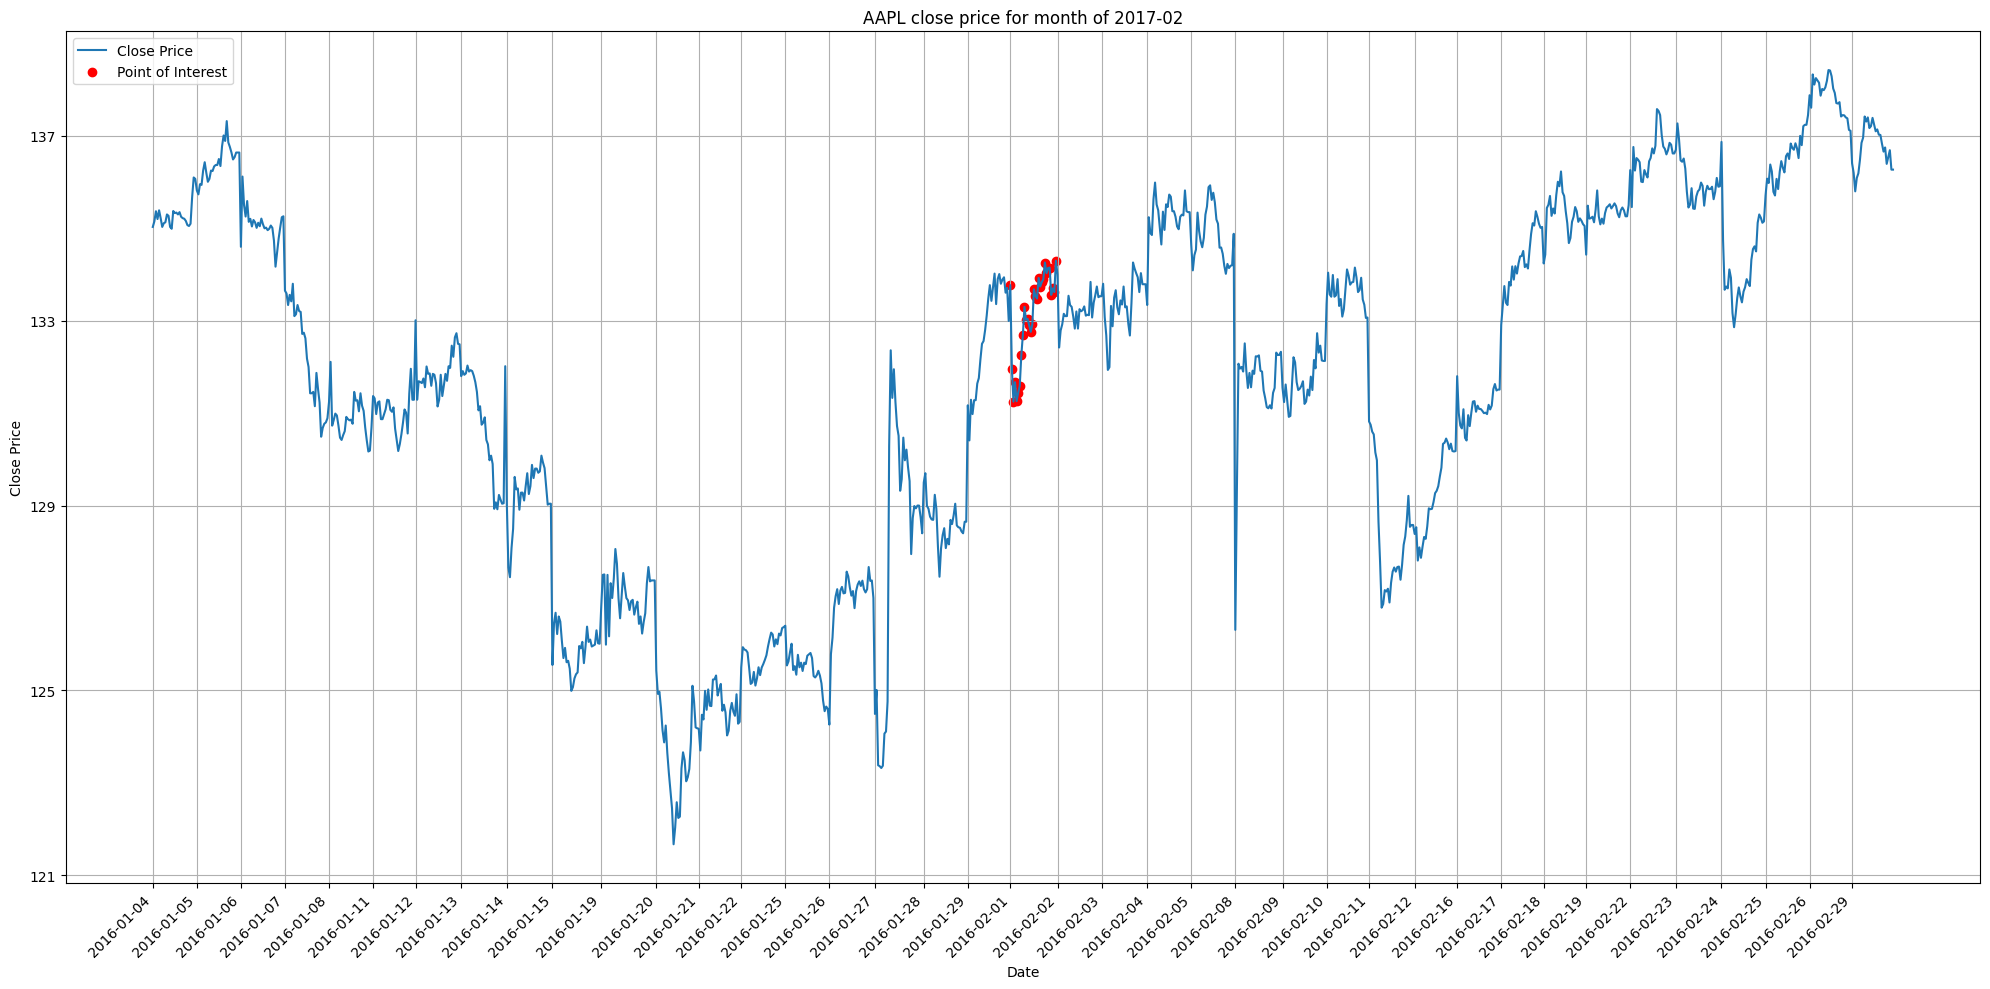

In [41]:
import matplotlib.pyplot as plt
import math

plt.figure(figsize=(20, 10))

plt.plot(df_merged.index, df_merged['close'], label='Close Price')

y_min = df_merged['close'].min()
y_max = df_merged['close'].max()
y_ticks = list(range(math.ceil(y_min -1), math.ceil(y_max + 1.5), math.ceil(abs(y_max - y_min) / 5)))
plt.yticks(y_ticks)

unique_dates = df_merged['date'].dt.strftime('%Y-%m-%d').unique()
tick_positions = [df_merged[df_merged['date'].dt.strftime('%Y-%m-%d') == date].index[0] for date in unique_dates]
plt.xticks(ticks=tick_positions, labels=unique_dates, rotation=45, ha='right')
plt.scatter(contractInterval.index, contractInterval['close'], color='red', label='Point of Interest')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('AAPL close price for month of 2017-02')
plt.grid()

plt.tight_layout()
plt.legend()
plt.show()


In [115]:
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
df['volatility_3'] = df['log_returns'].rolling(window=2).std() * np.sqrt(252) 
df['moving_avg2'] = df['close'].rolling(window=2).mean()
df['moving_avg3'] = df['close'].rolling(window=3).mean()
df['moving_avg4'] = df['close'].rolling(window=4).mean()

#RSI
delta = df['close'].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain).rolling(window=5).mean()
avg_loss = pd.Series(loss).rolling(window=5).mean()
rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))

df

,date,open,high,low,close,volume,log_returns,volatility_3,moving_avg,moving_avg2,moving_avg3,moving_avg4,rsi
0,2017-02-01 04:00:00,28.8226,28.9152,28.8226,28.8805,14752.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-02-01 04:15:00,28.8805,28.9268,28.8805,28.9268,8492.0,0.001602,NaN,28.90365,28.90365,NaN,NaN,NaN
2,2017-02-01 04:30:00,28.9129,28.9245,28.8967,28.8967,16860.0,-0.001041,0.029667,28.91175,28.91175,28.901333,NaN,NaN
3,2017-02-01 04:45:00,28.8920,28.8920,28.8781,28.8781,5360.0,-0.000644,0.004459,28.88740,28.88740,28.900533,28.895525,NaN
4,2017-02-01 05:00:00,28.8689,28.8712,28.8689,28.8712,5636.0,-0.000239,0.004545,28.87465,28.87465,28.882000,28.893200,45.436703
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142,2017-02-28 18:45:00,31.8320,31.8483,31.8320,31.8413,9888.0,-0.000220,0.007403,31.84480,31.84480,31.841300,31.841300,54.935622
1143,2017-02-28 19:00:00,31.8413,31.8483,31.8343,31.8483,23688.0,0.000220,0.004935,31.84480,31.84480,31.845967,31.843050,50.000000
1144,2017-02-28 19:15:00,31.8529,31.8576,31.8506,31.8529,21288.0,0.000144,0.000846,31.85060,31.85060,31.847500,31.847700,64.646465
1145,2017-02-28 19:30:00,31.8529,31.8576,31.8529,31.8576,5200.0,0.000148,0.000035,31.85525,31.85525,31.852933,31.850025,81.233244
